## Build the dataset

In [28]:
%run ./nn-basics-prepare-data.ipynb

import random
random.seed(42)
random.shuffle(examples)

block_size = 8

n1 = int(0.8 * len(examples))
n2 = int(0.9 * len(examples))
print("Training: ", end='')
Xtr, Ytr = build_dataset(examples[:n1], block_size)
print("Validation: ", end='')
Xval, Yval = build_dataset(examples[n1:n2], block_size)
print("Testing: ", end='')
Xtest, Ytest = build_dataset(examples[n2:], block_size)

Rachel Green
Well, can I keep the presents and still be 29?
Dictionary size: 68
{' ': 1, '!': 2, "'": 3, ',': 4, '.': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '?': 16, 'A': 17, 'B': 18, 'C': 19, 'D': 20, 'E': 21, 'F': 22, 'G': 23, 'H': 24, 'I': 25, 'J': 26, 'K': 27, 'L': 28, 'M': 29, 'N': 30, 'O': 31, 'P': 32, 'Q': 33, 'R': 34, 'S': 35, 'T': 36, 'U': 37, 'V': 38, 'W': 39, 'X': 40, 'Y': 41, 'Z': 42, 'a': 43, 'b': 44, 'c': 45, 'd': 46, 'e': 47, 'f': 48, 'g': 49, 'h': 50, 'i': 51, 'j': 52, 'k': 53, 'l': 54, 'm': 55, 'n': 56, 'o': 57, 'p': 58, 'q': 59, 'r': 60, 's': 61, 't': 62, 'u': 63, 'v': 64, 'w': 65, 'x': 66, 'y': 67, 'z': 68}
Training: torch.Size([2605041, 8]) torch.Size([2605041])
Validation: torch.Size([317795, 8]) torch.Size([317795])
Testing: torch.Size([327782, 8]) torch.Size([327782])


## "Torchify" our implementations

Make our implementation follows the API design in PyTorch, e.g.,
```python
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,20,5),
    torch.nn.ReLU(),
    torch.nn.Conv2d(20,64,5),
    torch.nn.ReLU()
)

```

In [31]:
import torch
import torch.nn.functional as F


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# Map the context characters to an embedding vector
class Embedding:
    def __init__(self, vocab_size, embedding_dim):
        self.embedding_dim = embedding_dim
        self.weight = torch.randn((vocab_size, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # moving average
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize input
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [32]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## WaveNet

WaveNet is a 1D CNN (todo).

(todo: image)

In [33]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [38]:
n_embd = 10
n_hidden = 128
vocab_size = len(stoi)

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# init parameters
with torch.no_grad():
    # make less layer less confident
    model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

78455


In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(len(Xtr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    lossi.append(loss.item())
    if i % 1000 == 0:
        print(i, loss.item())

    # Remove after making sure the code works
    # if i >= 5000:
    #     break

0 4.504487037658691
1000 2.6220247745513916
2000 2.365464210510254
3000 2.3978288173675537
4000 2.6166396141052246
5000 2.556673526763916
6000 2.4080283641815186
7000 2.4187071323394775
8000 2.154144287109375
9000 2.7413442134857178
10000 2.2810401916503906
11000 2.200671911239624
12000 1.9701505899429321
13000 1.975038766860962
14000 2.224851608276367
15000 2.3830270767211914
16000 1.4358891248703003
17000 1.9348161220550537
18000 2.2088029384613037
19000 2.0596096515655518
20000 2.0203070640563965
21000 1.6373283863067627
22000 1.443886160850525
23000 2.1929640769958496
24000 1.958490252494812
25000 1.7386469841003418
26000 2.1171717643737793
27000 1.9065550565719604
28000 2.441685199737549
29000 1.6627631187438965
30000 2.047149419784546
31000 2.7627854347229004
32000 1.922777533531189
33000 2.2903003692626953
34000 1.9977060556411743
35000 2.0070340633392334
36000 2.3723671436309814
37000 1.5366169214248657
38000 1.7044614553451538
39000 2.0740602016448975
40000 1.7705204486846924


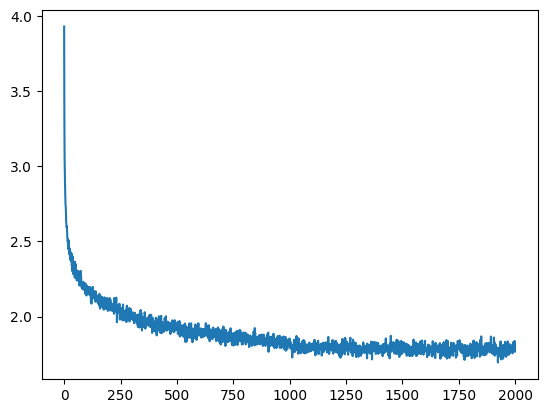

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(
    # lossi
    torch.tensor(lossi).view(-1, 100).mean(dim=1).flatten().tolist()
)

## Evaluation

In [42]:
for layer in model.layers:
    layer.training = False

In [44]:
def evaluation(X, Y):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
    return loss.item()

evaluation(Xtr, Ytr), evaluation(Xval, Yval)

(1.6969759464263916, 1.6934974193572998)

In [48]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        X = torch.tensor([context]) # (1, block_size)
        with torch.no_grad():
            logits = model(X)
            prob = F.softmax(logits, dim=1)
            ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join([itos[i] for i in out]))

Oh my God! That's like ontease 'it.
Oh I can't lot not gonna does loterder the get this is of. We at's to you meor, but wascryes it.
What I do the ins. well yours.
I may a secfirthe'd that's not gonna know......I'd Bo to Stein.
Oh homall bigbit?
In tish.
Reastand then insiar, everying the preet?
I knay, hey, she ganss stumpreanding in out 1 be some.
This nowonow.!
Why cine ume.
